<a href="https://colab.research.google.com/github/pabloknappo/spectrogram-learning/blob/main/timeseries_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
!sudo apt-get install git-lfs
!git lfs install
! git clone https://github.com/pabloknappo/spectrogram-learning/

Detected operating system as Ubuntu/bionic.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... done.
Running apt-get update... done.

The repository is setup! You can now install packages.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 59 not upgraded.
Need to get 6,526 kB of archives.
After this operation, 14.7 MB of additional disk space will be used.
Get:1 https://packagecloud.io/github/git-lfs/ubuntu bionic/main amd64 git-lfs amd64 3.0.2 [6,526 kB]
Fetched 6,526 kB in 1s (11.0 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [2]:
import os

os.chdir("spectrogram-learning/timeseries_data/")
         
! ls

bearing_dataset.csv  bearing_labels.csv  labels.txt


In [3]:
"""
Title: Timeseries classification from scratch
Author: [hfawaz](https://github.com/hfawaz/)
Date created: 2020/07/21
Last modified: 2021/07/16
Description: Training a timeseries classifier from scratch on the FordA dataset from the UCR/UEA archive.
"""
"""
## Introduction
This example shows how to do timeseries classification from scratch, starting from raw
CSV timeseries files on disk. We demonstrate the workflow on the FordA dataset from the
[UCR/UEA archive](https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/).
"""

"""
## Setup
"""

from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

"""
## Load the data: the FordA dataset
### Dataset description
The dataset we are using here is called FordA.
The data comes from the UCR archive.
The dataset contains 3601 training instances and another 1320 testing instances.
Each timeseries corresponds to a measurement of engine noise captured by a motor sensor.
For this task, the goal is to automatically detect the presence of a specific issue with
the engine. The problem is a balanced binary classification task. The full description of
this dataset can be found [here](http://www.j-wichard.de/publications/FordPaper.pdf).
### Read the TSV data
We will use the `FordA_TRAIN` file for training and the
`FordA_TEST` file for testing. The simplicity of this dataset
allows us to demonstrate effectively how to use ConvNets for timeseries classification.
In this file, the first column corresponds to the label.
"""



X = np.loadtxt("bearing_dataset.csv", delimiter=",")
Y = np.loadtxt("bearing_labels.csv", delimiter=",")

Y = Y.astype(int)

X = np.transpose(X)
print("Data array shape: " + str(X.shape))
print("Labels array shape: " + str(Y.shape))

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Data array shape: (1797, 11025)
Labels array shape: (1797,)


In [7]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1437, 11025)
(1437,)
(360, 11025)
(360,)


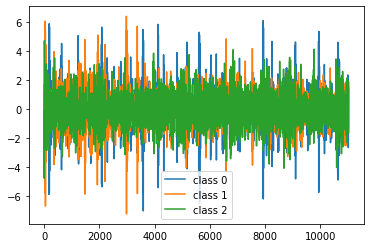

In [8]:
"""
## Visualize the data
Here we visualize one timeseries example for each class in the dataset.
"""

classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

In [9]:
"""
## Standardize the data
Our timeseries are already in a single length (500). However, their values are
usually in various ranges. This is not ideal for a neural network;
in general we should seek to make the input values normalized.
For this specific dataset, the data is already z-normalized: each timeseries sample
has a mean equal to zero and a standard deviation equal to one. This type of
normalization is very common for timeseries classification problems, see
[Bagnall et al. (2016)](https://link.springer.com/article/10.1007/s10618-016-0483-9).
Note that the timeseries data used here are univariate, meaning we only have one channel
per timeseries example.
We will therefore transform the timeseries into a multivariate one with one channel
using a simple reshaping via numpy.
This will allow us to construct a model that is easily applicable to multivariate time
series.
"""

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [12]:
print(x_train.shape)
print(x_test.shape)
print(y_train)
print(y_test)

(1437, 11025, 1)
(360, 11025, 1)
[2 1 2 ... 1 2 1]
[2 0 2 0 2 1 1 2 1 2 1 1 0 2 2 2 0 0 2 1 0 2 0 2 2 0 1 0 2 1 1 0 1 0 1 1 2
 2 2 0 2 0 0 1 2 0 1 0 1 2 0 1 1 0 0 0 0 2 1 0 2 2 2 0 1 2 1 2 2 2 0 1 2 0
 1 2 2 0 1 2 0 0 2 0 0 0 2 0 0 2 2 0 1 0 1 0 0 1 0 1 0 1 2 2 0 2 1 1 0 0 0
 1 0 1 0 2 0 1 0 1 1 2 2 1 1 2 1 0 0 0 2 2 1 0 1 0 0 0 1 2 0 2 1 2 0 0 1 2
 0 2 0 2 1 0 1 1 1 0 1 0 2 1 2 0 2 1 2 1 1 0 0 0 2 0 2 0 1 1 2 2 2 0 1 0 2
 1 2 0 0 1 2 2 0 2 1 0 2 0 1 0 1 1 1 1 2 0 2 0 2 0 1 1 1 2 1 1 2 0 1 2 0 0
 0 0 2 2 0 2 2 1 0 2 0 2 1 0 1 2 2 1 0 2 2 0 1 0 0 2 2 2 2 2 2 2 1 1 0 2 1
 1 0 0 0 2 2 2 2 1 0 1 1 2 2 2 2 0 1 2 2 1 1 0 2 0 1 1 1 2 1 2 0 0 0 0 2 2
 0 2 0 1 0 2 2 2 1 1 0 1 2 2 1 1 0 1 2 2 0 2 1 0 0 2 0 0 1 2 0 0 2 1 2 2 2
 0 0 1 0 1 0 2 1 2 2 1 0 1 0 1 0 0 0 2 2 0 2 2 2 1 1 2]


In [14]:
"""
Finally, in order to use `sparse_categorical_crossentropy`, we will have to count
the number of classes beforehand.
"""

num_classes = len(np.unique(y_train))
print(num_classes)

3


In [ ]:

"""
Now we shuffle the training set because we will be using the `validation_split` option
later when training.
"""

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

In [ ]:
"""
Standardize the labels to positive integers.
The expected labels will then be 0 and 1.
"""

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

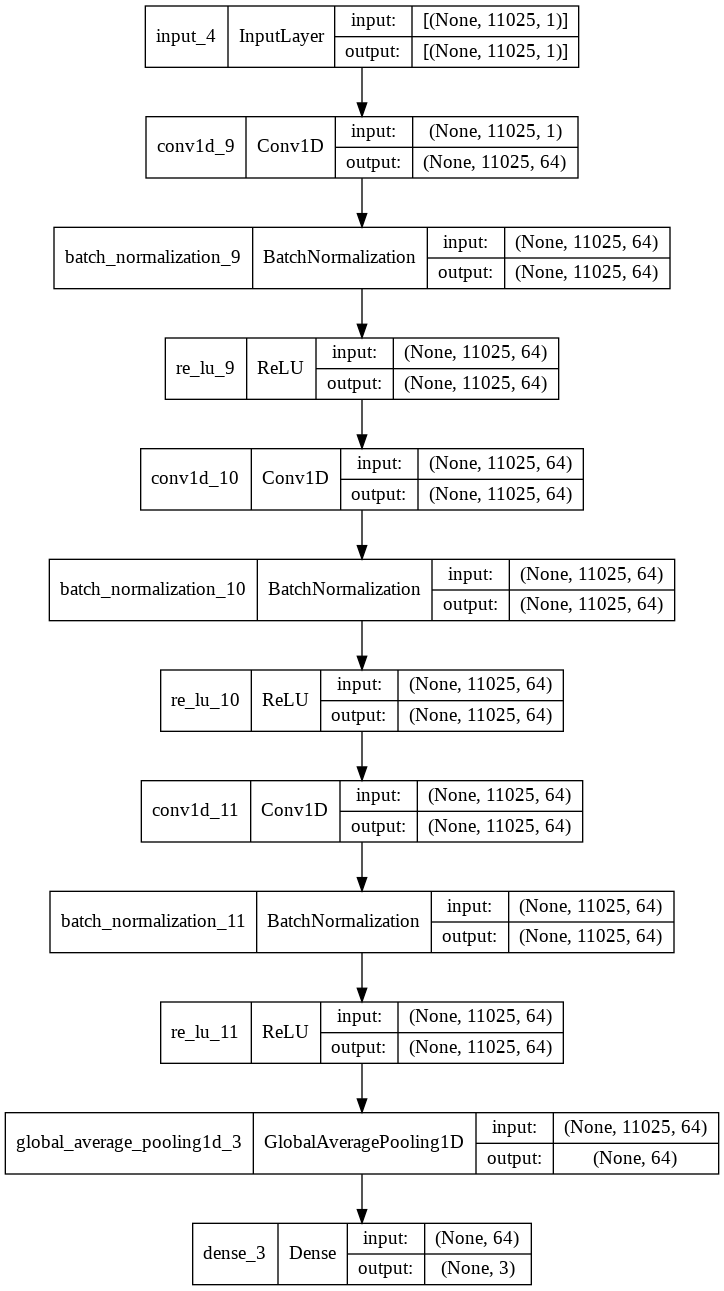

In [24]:
"""
## Build a model
We build a Fully Convolutional Neural Network originally proposed in
[this paper](https://arxiv.org/abs/1611.06455).
The implementation is based on the TF 2 version provided
[here](https://github.com/hfawaz/dl-4-tsc/).
The following hyperparameters (kernel_size, filters, the usage of BatchNorm) were found
via random search using [KerasTuner](https://github.com/keras-team/keras-tuner).
"""


def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)
    #conv1 = keras.layers.Dropout(0.2)(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)
    #conv2 = keras.layers.Dropout(0.2)(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)
    #conv3 = keras.layers.Dropout(0.2)(conv3)
    

    gap = keras.layers.GlobalAveragePooling1D()(conv3)
    #gap = keras.layers.Dropout(0.5)(gap)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)



In [20]:
print(x_train.shape[1:])

(11025, 1)


In [30]:
"""
## Train the model
"""

epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.1, patience=5, min_lr=0.000001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, verbose=1),
]

from tensorflow.keras.optimizers import SGD
opt = SGD()

model.compile(
    optimizer=opt,
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
36/36 [==============================] - 184s 5s/step - loss: 0.5336 - sparse_categorical_accuracy: 0.9608 - val_loss: 0.6901 - val_sparse_categorical_accuracy: 0.8472 - lr: 0.0100
Epoch 2/500
36/36 [==============================] - 100s 3s/step - loss: 0.4979 - sparse_categorical_accuracy: 0.9695 - val_loss: 0.6441 - val_sparse_categorical_accuracy: 0.9028 - lr: 0.0100
Epoch 3/500
36/36 [==============================] - 100s 3s/step - loss: 0.4635 - sparse_categorical_accuracy: 0.9817 - val_loss: 0.5974 - val_sparse_categorical_accuracy: 0.9618 - lr: 0.0100
Epoch 4/500
36/36 [==============================] - 98s 3s/step - loss: 0.4339 - sparse_categorical_accuracy: 0.9809 - val_loss: 0.5566 - val_sparse_categorical_accuracy: 0.9757 - lr: 0.0100
Epoch 5/500
36/36 [==============================] - 97s 3s/step - loss: 0.4081 - sparse_categorical_accuracy: 0.9869 - val_loss: 0.5183 - val_sparse_categorical_accuracy: 0.9792 - lr: 0.0100
Epoch 6/500
36/36 [==================

12/12 [==============================] - 7s 545ms/step - loss: 0.0120 - sparse_categorical_accuracy: 1.0000
Test accuracy 1.0
Test loss 0.012041277252137661


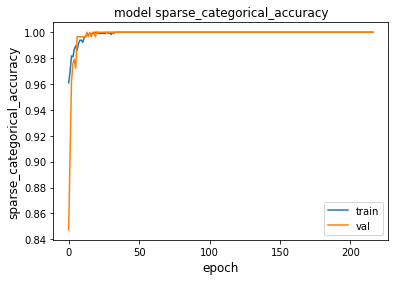

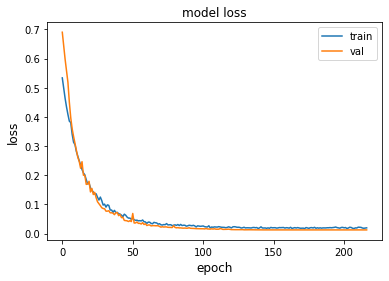

'\nWe can see how the training accuracy reaches almost 0.95 after 100 epochs.\nHowever, by observing the validation accuracy we can see how the network still needs\ntraining until it reaches almost 0.97 for both the validation and the training accuracy\nafter 200 epochs. Beyond the 200th epoch, if we continue on training, the validation\naccuracy will start decreasing while the training accuracy will continue on increasing:\nthe model starts overfitting.\n'

In [35]:
"""
## Evaluate model on test data
"""

model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

"""
## Plot the model's training and validation loss
"""

metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()


metric = "loss"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

"""
We can see how the training accuracy reaches almost 0.95 after 100 epochs.
However, by observing the validation accuracy we can see how the network still needs
training until it reaches almost 0.97 for both the validation and the training accuracy
after 200 epochs. Beyond the 200th epoch, if we continue on training, the validation
accuracy will start decreasing while the training accuracy will continue on increasing:
the model starts overfitting.
"""

In [32]:
from google.colab import files

files.download("best_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
x_train.shape[1:]

(11025, 1)

In [34]:
num_classes = len(np.unique(y_train))
print(num_classes)

3
